# Задание 5.

Загрузите [данные по изменению температуры поверхности земли](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data). Для этого может понадобится зарегистрироваться на [Kaggle](https://kaggle.com). Затем нужно будет работать с данными, которые содержатся в файле **GlobalLandTemperaturesByMajorCity.csv**

**NB** Все подсчеты необходимо делать с помощью `PySpark`, без применения `pandas api`. Можно использоать `SQL`.

In [2]:
import zipfile

import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

%matplotlib inline

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("PySpark") \
    .getOrCreate()

with zipfile.ZipFile("D:/big-data-2023/alms-bd-2023-3cecad0d39f8/data/GlobalLandTemperaturesByMajorCity.csv.zip") as z:
    with z.open("GlobalLandTemperaturesByMajorCity.csv") as f:
        pandas_df = pd.read_csv(f)
        df = spark.createDataFrame(pandas_df)

df.show(10)

+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1849-01-01|            26.704|                        1.435|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-02-01|            27.434|                        1.362|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-03-01|            28.101|                        1.612|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-04-01|             26.14|           1.3869999999999998|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-05-01|            25.427|                          1.2|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-06-01|            24.844|                        1.402|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-07-01|24.058000000000003|                        1.254|Abidjan|Côte

# Задание 3.1 (1 балл)

В последующих заданиях будут учитываться данные начиная с 01.01.1950. Для этого создайте новый `DataFrame`, в котором удалены все строки до 01.01.1950. Используйте созданный DataFrame в последующих заданиях.  

In [87]:
from pyspark.sql.functions import col

df_mini = df.filter(col("dt") >= '1950-01-01')

df_mini.show(18)

+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1950-01-01|26.773000000000003|                        0.239|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-02-01|            27.527|                        0.348|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-03-01|            28.344|                        0.431|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-04-01|             27.83|                        0.467|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-05-01|            26.896|                        0.248|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-06-01|            25.454|                        0.209|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-07-01|            24.878|                        0.403|Abidjan|Côte

# Задание 3.2 (2 балла)

Постройте график среднегодовых температур в городе Торонто.

In [21]:
from pyspark.sql.functions import year, avg

df_toronto_yearly_mean = df_mini.filter(col("City") == "Toronto").groupBy(year("dt").alias("year")).agg(avg("AverageTemperature").alias("mean_temperature")).sort(col("year"))
df_toronto_yearly_mean.show()

+----+------------------+
|year|  mean_temperature|
+----+------------------+
|1950| 5.639583333333335|
|1951| 6.259083333333334|
|1952| 7.013416666666667|
|1953|7.5062500000000005|
|1954| 6.243083333333332|
|1955| 6.974750000000001|
|1956| 5.745750000000001|
|1957| 6.424916666666667|
|1958| 5.624333333333333|
|1959| 6.403750000000001|
|1960| 5.896833333333334|
|1961| 6.461666666666666|
|1962| 5.891333333333333|
|1963| 5.486583333333335|
|1964| 6.504083333333333|
|1965| 5.590666666666667|
|1966| 6.027999999999999|
|1967|            5.6565|
|1968| 6.112666666666667|
|1969|6.0343333333333335|
+----+------------------+
only showing top 20 rows



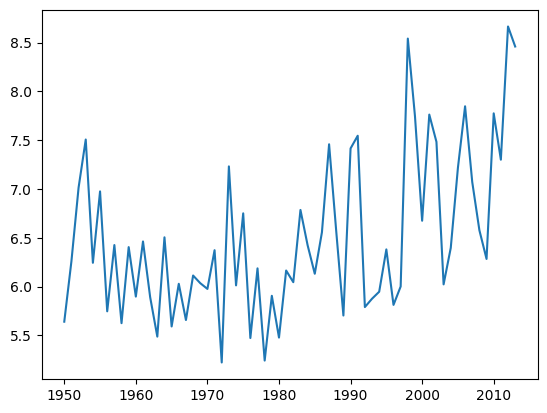

In [22]:
rdd_toronto_yearly_mean = df_toronto_yearly_mean.rdd

years = rdd_toronto_yearly_mean.map(lambda x: x.year).collect()
mean_temperatures = rdd_toronto_yearly_mean.map(lambda x: x.mean_temperature).collect()

plt.plot(years, mean_temperatures)
plt.show()


# Задание 3.3 (2 балла)

Найдите город, для которого выборочная дисперсия температур на приведенных данных максимальна. 

In [88]:
from pyspark.sql.functions import var_pop, max

df_mini_Var = df_mini.dropna().groupBy("City").agg(var_pop("AverageTemperature").alias("VarTemperature"))
max_var = df_mini_Var.agg(max("VarTemperature")).collect()[0][0]
df_mini_Var = df_mini_Var.filter(df_mini_Var.VarTemperature == max_var)
df_mini_Var.show()

+------+------------------+
|  City|    VarTemperature|
+------+------------------+
|Harbin|218.61209943879504|
+------+------------------+



# Задание 3.4 (4 балла)

На одной оси постройте графики, отображающие:
1. Зависимость выборочной дисперсии температур от широты города (Latitude).
2. Зависимость средней температуры в январе 1975 года от широты города (Latitude).
3. Зависимость средней температуры в июле 1975 года от широты города (Latitude).

In [89]:
df_mini = df_mini.join(df_mini_Var.select("City", "VarTemperature"), on="City", how="left")
df_mini.show()

+-------+----------+------------------+-----------------------------+-------------+--------+---------+--------------+
|   City|        dt|AverageTemperature|AverageTemperatureUncertainty|      Country|Latitude|Longitude|VarTemperature|
+-------+----------+------------------+-----------------------------+-------------+--------+---------+--------------+
|Abidjan|1950-01-01|26.773000000000003|                        0.239|Côte D'Ivoire|   5.63N|    3.23W|          null|
|Abidjan|1950-02-01|            27.527|                        0.348|Côte D'Ivoire|   5.63N|    3.23W|          null|
|Abidjan|1950-03-01|            28.344|                        0.431|Côte D'Ivoire|   5.63N|    3.23W|          null|
|Abidjan|1950-04-01|             27.83|                        0.467|Côte D'Ivoire|   5.63N|    3.23W|          null|
|Abidjan|1950-05-01|            26.896|                        0.248|Côte D'Ivoire|   5.63N|    3.23W|          null|
|Abidjan|1950-06-01|            25.454|                 

In [167]:
from pyspark.sql.functions import when, regexp_replace, expr

df_mini = df_mini.withColumn("Longitude", 
                             when(df_mini["Longitude"].contains("E"), 
                                  regexp_replace(df_mini["Longitude"], "E", "")
                                  .cast("double"))
                             .when(df_mini["Longitude"].contains("W"), 
                                   expr("regexp_replace(Longitude, 'W', '') * -1")
                                   .cast("double"))
                             .otherwise(df_mini["Longitude"]))


df_mini = df_mini.withColumn("Latitude", 
                             when(df_mini["Latitude"].contains("N"), 
                                  regexp_replace(df_mini["Latitude"], "N", "")
                                  .cast("double"))
                             .when(df_mini["Latitude"].contains("S"), 
                                   expr("regexp_replace(Latitude, 'S', '') * -1")
                                   .cast("double"))
                             .otherwise(df_mini["Latitude"])).sort(col("Latitude"))


In [93]:
df_mini.show()

+-------+----------+------------------+-----------------------------+-------------+--------+---------+--------------+
|   City|        dt|AverageTemperature|AverageTemperatureUncertainty|      Country|Latitude|Longitude|VarTemperature|
+-------+----------+------------------+-----------------------------+-------------+--------+---------+--------------+
|Abidjan|1950-01-01|26.773000000000003|                        0.239|Côte D'Ivoire|    5.63|    -3.23|          null|
|Abidjan|1950-02-01|            27.527|                        0.348|Côte D'Ivoire|    5.63|    -3.23|          null|
|Abidjan|1950-03-01|            28.344|                        0.431|Côte D'Ivoire|    5.63|    -3.23|          null|
|Abidjan|1950-04-01|             27.83|                        0.467|Côte D'Ivoire|    5.63|    -3.23|          null|
|Abidjan|1950-05-01|            26.896|                        0.248|Côte D'Ivoire|    5.63|    -3.23|          null|
|Abidjan|1950-06-01|            25.454|                 

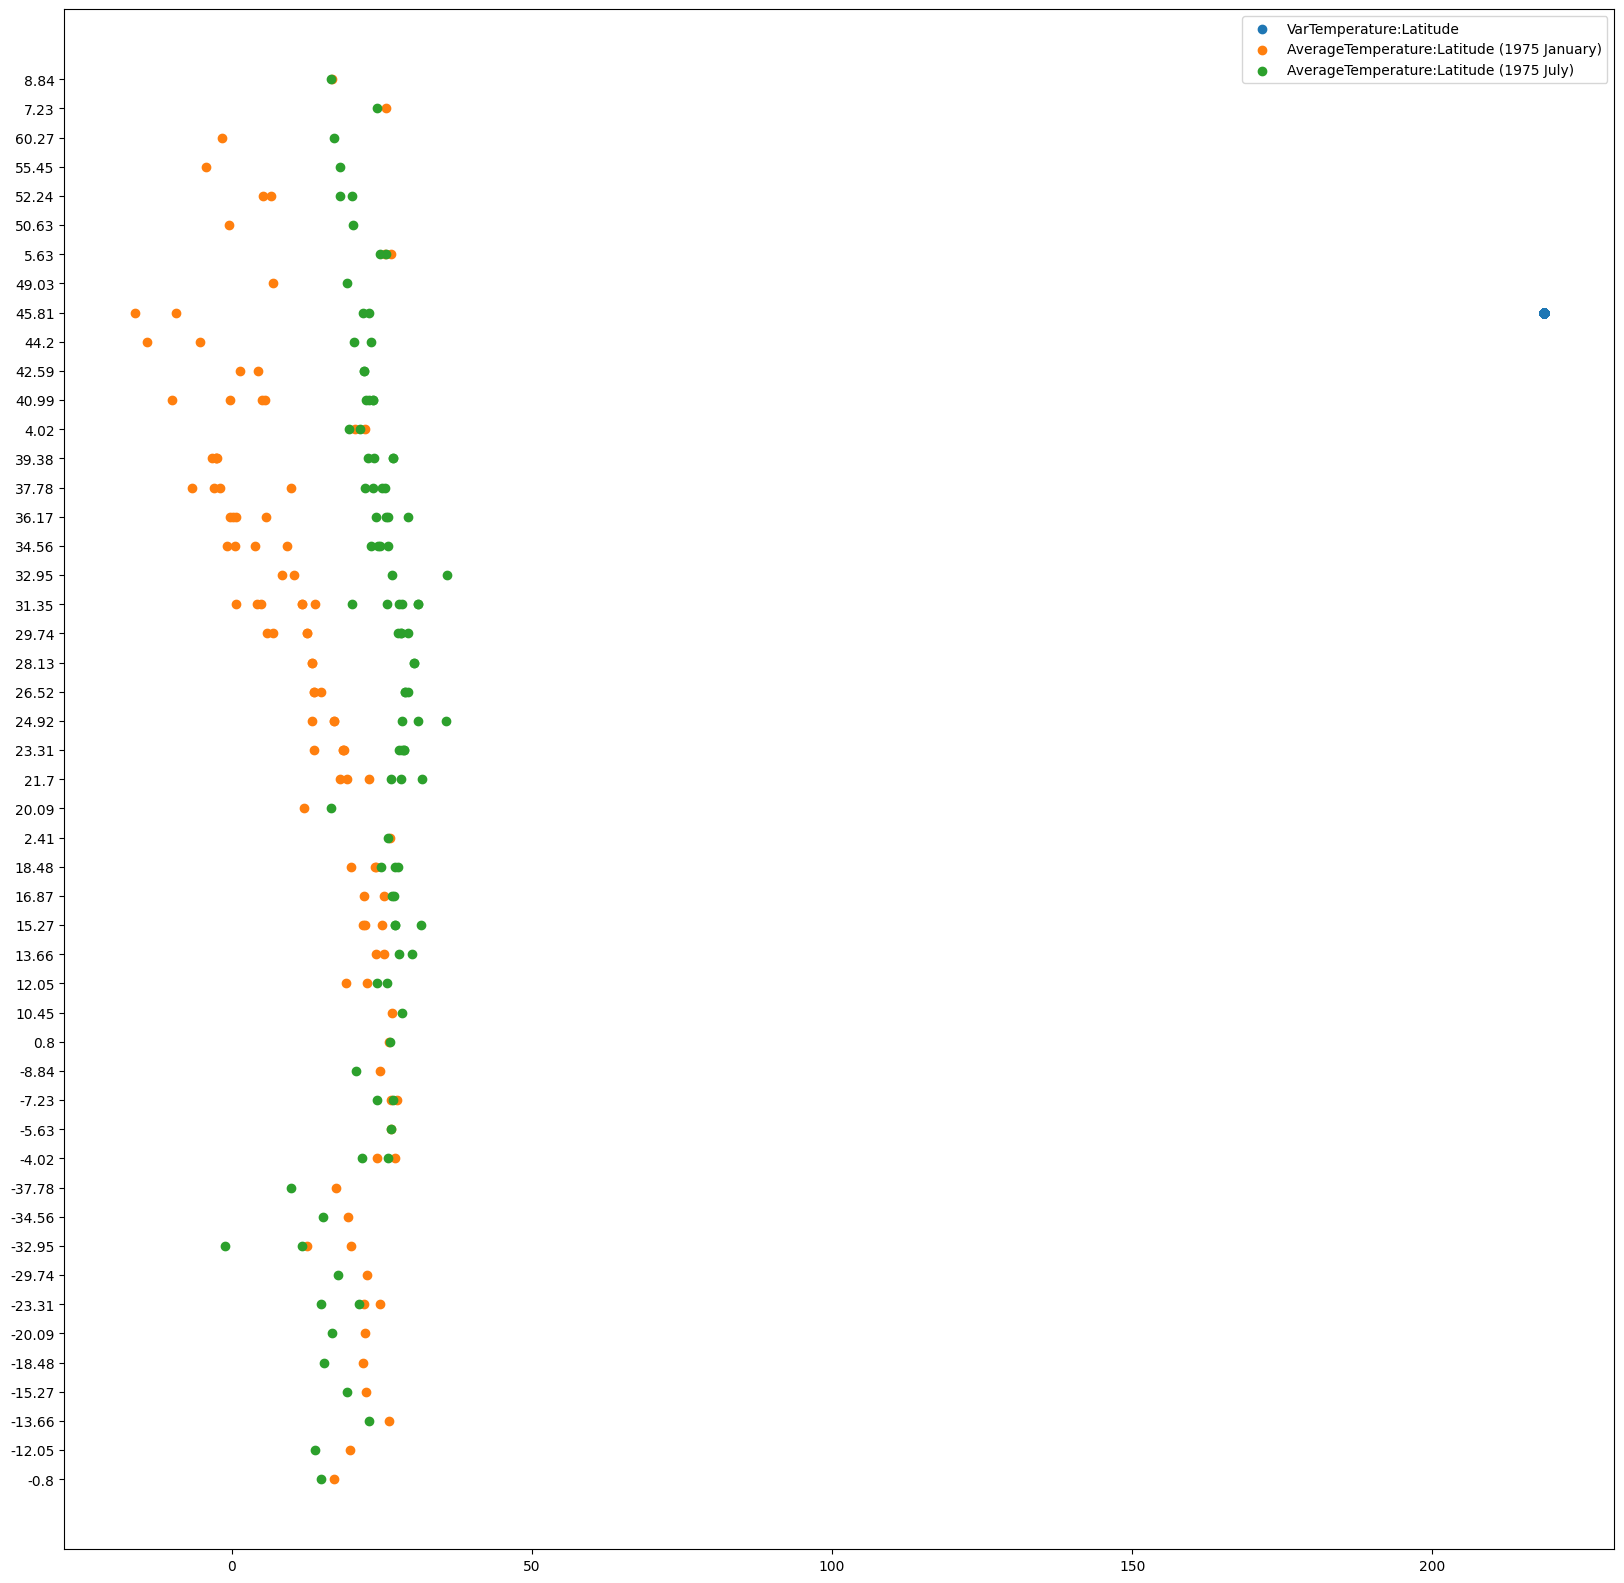

In [169]:
# 1)
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(df_mini.select(col("Latitude")).rdd.flatMap(lambda x: x).collect(),
            df_mini.select(col("VarTemperature")).rdd.flatMap(lambda x: x).collect(),
           label="VarTemperature:Latitude")

# 2)
ax.scatter(
           df_mini.filter(col("dt") == "1975-01-01").select(col("Latitude")).rdd.flatMap(lambda x: x).collect(),
           df_mini.filter(col("dt") == "1975-01-01").select(col("AverageTemperature")).rdd.flatMap(lambda x: x).collect(),
           label="AverageTemperature:Latitude (1975 January)")

# 3)
ax.scatter(
           df_mini.filter(col("dt") == "1975-07-01").select(col("Latitude")).rdd.flatMap(lambda x: x).collect(),
           df_mini.filter(col("dt") == "1975-07-01").select(col("AverageTemperature")).rdd.flatMap(lambda x: x).collect(),
           label="AverageTemperature:Latitude (1975 July)")

ax.legend()
plt.show()

# Задание 3.5 (6 баллов)

Посчитайте данные по среднегодовой температуре в Санкт-Петербурге. Определите года, в которых средняя температура была выше, чем в предыдущем  и последующем году. Постройте график среднегодовой температуры и обозначьте на нём найденные года (произвольным образом). 

Постройте модель линейной регрессии (можно использовать [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)): $\mathbb{год} \rightarrow \mathbb{средняя\_температура}$. Отобразите прямую на предыдущем графике. 

In [214]:
import numpy as np


def calculate_slope(x, y):
    mx = np.array([i - np.mean(x) for i in x])
    my = np.array([i - np.nanmean(y) for i in y])
    result = np.nansum(mx * my) / np.sum(mx**2)
    return result
    
def get_params(x, y):    
    a = calculate_slope(x, y)
    b = np.nanmean(y) - a * np.mean(x)
    return a, b

Years:  [1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]


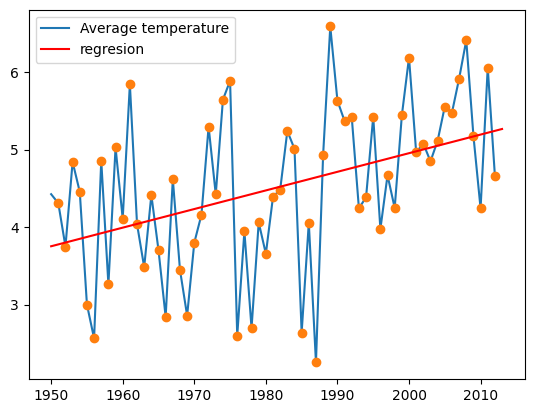

In [216]:
from pyspark.sql.functions import year, avg, lag, lead
from pyspark.sql.window import Window

df_peter_yearly_mean = df_mini.filter(df_mini.City == 'Saint Petersburg') \
    .groupBy(year('dt').alias('year')) \
    .agg(avg('AverageTemperature').alias('AverageTemperature'))

window = Window.orderBy('year')

df_peter_yearly_mean_special = df_peter_yearly_mean \
    .withColumn('previous', lag('AverageTemperature', 1).over(window)) \
    .withColumn('next', lead('AverageTemperature', 1).over(window)) \
    .orderBy('year')

plt.plot(df_peter_yearly_mean_special.select('year').collect(),
         df_peter_yearly_mean_special.select('AverageTemperature').collect(),
         label='Average temperature')

x = df_peter_yearly_mean_special.sort("year").filter((df_peter_yearly_mean_special.next > 0) & (df_peter_yearly_mean_special.previous > 0)).select("year").collect()
y = df_peter_yearly_mean_special.sort("year").filter((df_peter_yearly_mean_special.next > 0) & (df_peter_yearly_mean_special.previous > 0)).select("AverageTemperature").collect()

x_lin = [row["year"] for row in df_peter_yearly_mean.sort("year").select("year").collect()]
y_lin = [row["AverageTemperature"] for row in df_peter_yearly_mean.sort("year").select("AverageTemperature").collect()]
a, b = get_params(x_lin, y_lin)
lin_reg = [a * year + b for year in x_lin]

print("Years: ", [row["year"] for row in x])
plt.plot([row["year"] for row in x], [row["AverageTemperature"] for row in y], 'o')
plt.plot([row["year"] for row in df_peter_yearly_mean.sort("year").select("year").collect()], lin_reg, color='red', label='regresion')
plt.legend()
plt.show()

# Задание 3.6 (4 балла)

Найдите города, для которых: 
1. Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна.
2. Самая большая средняя разница между средней температурой января и средней температурой июля.
3. Наибольшее среднее количество месяцев с отрицательной температурой в году.

In [252]:
from pyspark.sql import functions as F

df_city_temperatures = df_mini.dropna().groupBy("City") \
    .agg(F.min("AverageTemperature").alias("min_temperature"),
         F.max("AverageTemperature").alias("max_temperature"))

df_city_temperatures = df_city_temperatures.withColumn("temperature_diff", F.col("max_temperature") - F.col("min_temperature"))
max_diff = df_city_temperatures.agg(F.max("temperature_diff")).collect()[0][0]
df_cities_max_diff = df_city_temperatures.filter(F.col("temperature_diff") == max_diff)

df_cities_max_diff.show()


+------+---------------+---------------+------------------+
|  City|min_temperature|max_temperature|  temperature_diff|
+------+---------------+---------------+------------------+
|Harbin|        -23.922|         25.357|49.278999999999996|
+------+---------------+---------------+------------------+



In [260]:

# Filter the DataFrame for January and July months
df_mini_JaJu = df_mini.sort('dt').filter((F.month('dt') == 1) | (F.month('dt') == 7))

# Calculate the temperature difference between consecutive rows
df_mini_JaJu = df_mini_JaJu.withColumn('diff', F.col('AverageTemperature') - F.lag('AverageTemperature').over(Window.orderBy('dt')))

# Filter the DataFrame for July rows
df_mini_JaJu = df_mini_JaJu.sort('dt').filter(F.month('dt') == 7)

# Take the absolute value of the temperature difference
df_mini_JaJu = df_mini_JaJu.sort('dt').withColumn('diff', F.abs(F.col('diff')))

# Calculate the average temperature difference for each city
df_mini_JaJu_AvDiff = df_mini_JaJu.sort('dt').groupBy('City').agg(F.mean('diff').alias('average_diff'))

# Find the city with the maximum average temperature difference
max_diff_city = df_mini_JaJu_AvDiff.filter(F.col('average_diff') == df_mini_JaJu_AvDiff.agg(F.max('average_diff')).first()[0])

max_diff_city.show()

+-------------+------------+
|         City|average_diff|
+-------------+------------+
|Santo Domingo| 28.52078125|
+-------------+------------+



In [254]:
df_mini_neg = df_mini.filter(df_mini.AverageTemperature < 0)

df_mini_neg = df_mini_neg.groupBy("City", F.year("dt").alias("year")) \
    .agg(F.count("AverageTemperature").alias("count_negative_temp"))

df_mini_neg = df_mini_neg.groupBy("City") \
    .agg(F.mean("count_negative_temp").alias("average_count_negative_temp"))

max_count_city = df_mini_neg.filter(df_mini_neg.average_count_negative_temp == df_mini_neg.agg(F.max("average_count_negative_temp")).first()[0])

max_count_city.show()


+------+---------------------------+
|  City|average_count_negative_temp|
+------+---------------------------+
|Harbin|                    4.90625|
+------+---------------------------+



# Задание 3.7 (3 балла)

Отобразите города на карте, например с помощью [geopandas/folium](https://geopandas.org/en/stable/gallery/plotting_with_folium.html) или [plotly](https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html). Причем цвет метки должен соответствовать средней температуре в январе за последние 10 лет. 


**\***(+3 балла). Вычислите прямую с "трендом" по изменению средней температуры за год в каждом городе в период 1950-2013 (можно с помощью линейной регрессии, как в задании **3.5**). Отобразите города цветом, который зависит от угла наклона этой прямой. 


**\***(+1 балл) В дополнение к предыдущему пункту, используйте библиотеку [pwlf](https://pypi.org/project/pwlf/) с фиксированным числом сегментов и визуализируйте угол наклона последнего сегмента. 

In [262]:
from pyspark.sql import functions as F
import plotly.express as px

# Filter the DataFrame for January months starting from 2003
df_mini_10Y_Jan = df_mini.filter((df_mini['dt'] >= '2003-01-01') & (F.month('dt') == 1))

# Calculate the average temperature for each City, Latitude, and Longitude
df_mini_10Y_Jan = df_mini_10Y_Jan.groupby('City', 'Latitude', 'Longitude') \
    .agg(F.mean('AverageTemperature').alias('AverageTemperature'))

# Convert the PySpark DataFrame to Pandas DataFrame for visualization
df_mini_10Y_Jan_pd = df_mini_10Y_Jan.toPandas()

# Create a scatter plot on a geographical map using Plotly
fig = px.scatter_geo(df_mini_10Y_Jan_pd, 
                     lon="Longitude",
                     lat="Latitude",
                     color="AverageTemperature", 
                     hover_name="City")

fig.show()

# *Задание 3.8 (8 баллов)

Цель - создать проект, который как минимум включает:
1. Использование юнит-тестов ([pytest](https://pytest.org)).
2. Применение средств форматирования и проверки исходного кода (например: [isort](https://pycqa.github.io/isort/), [black](https://black.readthedocs.io/en/stable/), [flake8](https://flake8.pycqa.org/en/latest/), [mypy](https://mypy.readthedocs.io/en/stable/)).
3. Спецификацию проекта в [pyproject.toml](https://pip.pypa.io/en/stable/reference/build-system/pyproject-toml/).
4. Использование утилит для работы с командной строкой ([argparse](https://docs.python.org/3/library/argparse.html), [click](https://click.palletsprojects.com/en/8.1.x/) и т.п.)
5. Сборку проекта в Wheel-файл.

Проект должен быть загружен в репозиторий. Функционал - произвольный, но должны использоваться данные из этого домашнего задания. Сам файл передается в качестве первого аргумента командной строки.  Например:

> python3 -m homeproject.app GlobalLandTemperaturesByMajorCity.csv 1980

Выдает самый жаркий месяц и город по наблюдениям за 1980 год.

*Ссылка на проект*